## Mask Detection using MobileNetV2

### Importing necessary libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Initialising the initial learning rate, number of epochs and batch size
INIT_LR = 1e-4
EPOCHS = 30
BS = 20

In [3]:
DIRECTORY = r"D:/Face Mask Detection Model/dataset"
CATEGORIES = ["mask", "withoutMask"]

In [4]:
# Initialising the list of data and labels
print("[INFO] loading images..")
data = []
labels = []

[INFO] loading images..


In [5]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

C:\Python39\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Encoding labels

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
data = np.array(data, dtype="uint8")
labels = np.array(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
            test_size=0.30, stratify=labels, random_state=48)

### Constructing training image generator for data augmentation

In [9]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### Creating Model

In [10]:
# Creating base model using MobileNetV2 
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [11]:
# Constructing head model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel) # to avoid overfitting of model
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# Placing headmodel over baseModel
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
for layer in baseModel.layers:
	layer.trainable = False

### Compiling Model

In [14]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [15]:
head = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/30
333/333 [==============================] - 245s 720ms/step - loss: 0.6181 - accuracy: 0.6850 - val_loss: 0.4662 - val_accuracy: 0.7931
Epoch 2/30
333/333 [==============================] - 181s 542ms/step - loss: 0.5137 - accuracy: 0.7624
Epoch 3/30
333/333 [==============================] - 180s 541ms/step - loss: 0.4793 - accuracy: 0.7815
Epoch 4/30
333/333 [==============================] - 132s 395ms/step - loss: 0.4730 - accuracy: 0.7803
Epoch 5/30
333/333 [==============================] - 94s 281ms/step - loss: 0.4540 - accuracy: 0.7893
Epoch 6/30
333/333 [==============================] - 93s 279ms/step - loss: 0.4463 - accuracy: 0.7965
Epoch 7/30
333/333 [==============================] - 94s 282ms/step - loss: 0.4386 - accuracy: 0.8005
Epoch 8/30
333/333 [==============================] - 99s 297ms/step - loss: 0.4317 - accuracy: 0.8050
Epoch 9/30
333/333 [==============================] - 95s 286ms/step - loss: 0.4277 - accuracy: 0.8041
Epoch 10/30
333/333 [======

### Making predictions on the model

In [16]:
pred = model.predict(testX, batch_size=BS)
pred = np.argmax(pred, axis=1)

144/144 [==============================] - 36s 247ms/step


In [17]:
print(classification_report(testY.argmax(axis=1), pred,
	target_names=lb.classes_))

              precision    recall  f1-score   support

        mask       0.85      0.81      0.83      1437
 withoutMask       0.81      0.86      0.83      1424

    accuracy                           0.83      2861
   macro avg       0.83      0.83      0.83      2861
weighted avg       0.83      0.83      0.83      2861



In [18]:
model.save("mask_detection.h5", save_format="h5")

### Plotting the accuracy

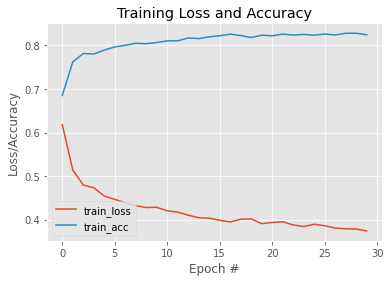

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), head.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")